                            Challenge 2: Anticipating Household Displacement in Communities

Map to visualize the potential neighborhoods experiencing vulnerability

Nur Afsa Syeda

In [1]:
#load libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import statsmodels.api as sm
import seaborn as sns

In [2]:
# Load the data
file_path = './data.csv'
data = pd.read_csv(file_path)

data.head()

,geoid,geoid_year,state,county,state_fips_code,county_fips_code,pov_pct_est,med_hh_inc_est,pop_pct_white,pop_pct_black,pop_pct_american_indian,pop_pct_asian,pop_pct_native_hawaiian,pop_pct_other_race,pop_pct_60plus_est,pop_pct_65plus_est,housecost_med_est,housecost_owner_est,housecost_rent_est
0,12097040807,2020,Florida,Osceola County,12,97,5.4,76582,78.4,2.6,0.0,3.7,0.0,7.4,28.8,22.7,1663,1791,1593
1,12097041101,2020,Florida,Osceola County,12,97,6.3,52466,44.6,22.4,0.8,0.5,0.0,15.7,20.3,13.1,1363,1197,1556
2,12097041302,2020,Florida,Osceola County,12,97,12.1,58267,38.4,17.1,0.0,1.0,0.0,29.4,13.8,9.9,1321,1271,1589
3,12097041502,2020,Florida,Osceola County,12,97,9.3,76035,52.9,16.1,0.0,6.2,0.0,11.6,23.0,16.6,1610,1611,1705
4,12097042000,2020,Florida,Osceola County,12,97,28.4,49278,40.5,5.3,0.0,3.5,0.0,40.2,12.2,6.1,1527,1738,1505


In [3]:
# Shapefile for Florida
shapefile_path = './tl_rd22_12_tract/tl_rd22_12_tract.shp'

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# print first few rows of data
gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,12,011,110403,12011110403,1104.03,Census Tract 1104.03,G5020,S,1323099,0,+25.9882712,-080.2428385,"POLYGON ((-80.24758 25.99480, -80.24754 25.994..."
1,12,011,060114,12011060114,601.14,Census Tract 601.14,G5020,S,2598912,0,+26.1864137,-080.2598783,"POLYGON ((-80.26810 26.19368, -80.26702 26.193..."
2,12,011,060120,12011060120,601.20,Census Tract 601.20,G5020,S,12814719,1823779,+26.1433192,-080.3341825,"POLYGON ((-80.36670 26.12828, -80.36649 26.128..."
3,12,011,110347,12011110347,1103.47,Census Tract 1103.47,G5020,S,2846117,545293,+26.0230637,-080.4006685,"POLYGON ((-80.40957 26.03541, -80.40878 26.035..."
4,12,011,020421,12011020421,204.21,Census Tract 204.21,G5020,S,1060862,16632,+26.2129463,-080.2358809,"POLYGON ((-80.24061 26.22083, -80.24056 26.220..."


## Data wrangling

In [4]:
#Check for missing values in each column
missing_values = [-666666666]
data.isin(missing_values).sum()

geoid                      0
geoid_year                 0
state                      0
county                     0
state_fips_code            0
county_fips_code           0
pov_pct_est                0
med_hh_inc_est             1
pop_pct_white              0
pop_pct_black              0
pop_pct_american_indian    0
pop_pct_asian              0
pop_pct_native_hawaiian    0
pop_pct_other_race         0
pop_pct_60plus_est         0
pop_pct_65plus_est         0
housecost_med_est          0
housecost_owner_est        1
housecost_rent_est         2
dtype: int64

In [5]:
# Create a new DataFrame by replaceing all occurrences of the missing values with NaN 
data_clean = data.replace(missing_values, np.nan)

In [6]:
# Check the information of the DataFrame
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   geoid                    59 non-null     int64  
 1   geoid_year               59 non-null     int64  
 2   state                    59 non-null     object 
 3   county                   59 non-null     object 
 4   state_fips_code          59 non-null     int64  
 5   county_fips_code         59 non-null     int64  
 6   pov_pct_est              59 non-null     float64
 7   med_hh_inc_est           58 non-null     float64
 8   pop_pct_white            59 non-null     float64
 9   pop_pct_black            59 non-null     float64
 10  pop_pct_american_indian  59 non-null     float64
 11  pop_pct_asian            59 non-null     float64
 12  pop_pct_native_hawaiian  59 non-null     float64
 13  pop_pct_other_race       59 non-null     float64
 14  pop_pct_60plus_est       59 

In [7]:
# Normalize 'med_hh_inc_est' by converting it from annual to monthly income
data_clean['med_hh_inc_monthly'] = data_clean['med_hh_inc_est'] / 12

In [8]:
# Calculate the cost burden household, homeowner, and rent percentage
data_clean['cost_burden_pct'] = data_clean['housecost_med_est'] / data_clean['med_hh_inc_monthly'] *100
data_clean['cost_burden_owner_pct'] = data_clean['housecost_owner_est'] / data_clean['med_hh_inc_monthly'] *100
data_clean['cost_burden_rent_pct'] = data_clean['housecost_rent_est'] / data_clean['med_hh_inc_monthly'] *100

In [9]:
# AMI for Osceola County
ami = 90400

# Convert AMI to a monthly value
ami_monthly = ami / 12

# Compute the % of AMI
data_clean['ami_pct'] = (data_clean['med_hh_inc_monthly'] / ami_monthly) * 100

In [10]:
data_clean.head()

,geoid,geoid_year,state,county,state_fips_code,county_fips_code,pov_pct_est,med_hh_inc_est,pop_pct_white,pop_pct_black,...,pop_pct_60plus_est,pop_pct_65plus_est,housecost_med_est,housecost_owner_est,housecost_rent_est,med_hh_inc_monthly,cost_burden_pct,cost_burden_owner_pct,cost_burden_rent_pct,ami_pct
0,12097040807,2020,Florida,Osceola County,12,97,5.4,76582.0,78.4,2.6,...,28.8,22.7,1663,1791.0,1593.0,6381.833333,26.058343,28.064036,24.961479,84.714602
1,12097041101,2020,Florida,Osceola County,12,97,6.3,52466.0,44.6,22.4,...,20.3,13.1,1363,1197.0,1556.0,4372.166667,31.174475,27.377730,35.588762,58.037611
2,12097041302,2020,Florida,Osceola County,12,97,12.1,58267.0,38.4,17.1,...,13.8,9.9,1321,1271.0,1589.0,4855.583333,27.205794,26.176052,32.725213,64.454646
3,12097041502,2020,Florida,Osceola County,12,97,9.3,76035.0,52.9,16.1,...,23.0,16.6,1610,1611.0,1705.0,6336.250000,25.409351,25.425133,26.908660,84.109513
4,12097042000,2020,Florida,Osceola County,12,97,28.4,49278.0,40.5,5.3,...,12.2,6.1,1527,1738.0,1505.0,4106.500000,37.184951,42.323146,36.649215,54.511062


In [11]:
# Summary statistics
data_clean.describe()

,geoid,geoid_year,state_fips_code,county_fips_code,pov_pct_est,med_hh_inc_est,pop_pct_white,pop_pct_black,pop_pct_american_indian,pop_pct_asian,...,pop_pct_60plus_est,pop_pct_65plus_est,housecost_med_est,housecost_owner_est,housecost_rent_est,med_hh_inc_monthly,cost_burden_pct,cost_burden_owner_pct,cost_burden_rent_pct,ami_pct
count,5.900000e+01,59.0,59.0,59.0,59.000000,58.000000,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,59.000000,58.000000,57.000000,58.000000,58.000000,57.000000,56.000000,58.000000
mean,1.209704e+10,2020.0,12.0,97.0,14.306780,64376.206897,52.318644,9.744068,0.269492,2.640678,...,19.627119,14.072881,1403.084746,1305.189655,1560.666667,5364.683908,27.491177,24.673936,31.374079,71.212618
std,1.015554e+03,0.0,0.0,0.0,9.192292,18472.249729,15.011059,8.522046,0.724986,2.412190,...,7.857894,5.926179,240.364973,353.976779,284.554560,1539.354144,6.510841,5.800327,8.153028,20.433905
min,1.209704e+10,2020.0,12.0,97.0,1.900000,30750.000000,20.800000,0.000000,0.000000,0.000000,...,9.100000,6.100000,913.000000,478.000000,745.000000,2562.500000,17.678667,14.702415,10.563006,34.015487
25%,1.209704e+10,2020.0,12.0,97.0,6.300000,51538.000000,40.950000,3.600000,0.000000,0.900000,...,15.600000,10.250000,1231.000000,1115.000000,1372.000000,4294.833333,23.874309,21.288179,26.213102,57.011062
50%,1.209704e+10,2020.0,12.0,97.0,12.800000,62306.500000,49.200000,7.600000,0.000000,1.700000,...,17.200000,12.600000,1362.000000,1269.000000,1589.000000,5192.208333,25.446494,23.957329,31.457746,68.923119
75%,1.209704e+10,2020.0,12.0,97.0,21.800000,76462.250000,63.100000,14.350000,0.100000,4.000000,...,22.800000,16.250000,1610.000000,1571.750000,1748.000000,6371.854167,31.948932,27.161410,36.904823,84.582135
max,1.209704e+10,2020.0,12.0,97.0,33.100000,112153.000000,81.400000,42.300000,4.300000,9.500000,...,61.400000,42.700000,1905.000000,2129.000000,2279.000000,9346.083333,50.653659,48.736489,53.385366,124.063053


In [12]:
# Convert the common merge columns to the same data type (string)
gdf['GEOID'] = gdf['GEOID'].astype(str)
data_clean['geoid'] = data_clean['geoid'].astype(str)

In [13]:
# Merge the shapefile with the data
gdf = gdf.merge(data_clean, left_on='GEOID', right_on='geoid')

gdf.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,pop_pct_60plus_est,pop_pct_65plus_est,housecost_med_est,housecost_owner_est,housecost_rent_est,med_hh_inc_monthly,cost_burden_pct,cost_burden_owner_pct,cost_burden_rent_pct,ami_pct
0,12,097,042702,12097042702,427.02,Census Tract 427.02,G5020,S,2559247,39379,...,15.6,9.3,1339,1080.0,1700.0,4573.916667,29.274692,23.612149,37.167271,60.715708
1,12,097,043301,12097043301,433.01,Census Tract 433.01,G5020,S,17895276,9362731,...,28.4,20.0,1610,1607.0,NaN,7502.833333,21.458560,21.418575,NaN,99.595133
2,12,097,040901,12097040901,409.01,Census Tract 409.01,G5020,S,12166044,0,...,17.0,10.6,1685,1541.0,1857.0,7067.333333,23.842090,21.804547,26.275823,93.814159
3,12,097,043203,12097043203,432.03,Census Tract 432.03,G5020,S,4048477,347383,...,27.3,19.1,1048,849.0,1629.0,4340.250000,24.146075,19.561085,37.532400,57.613938
4,12,097,042701,12097042701,427.01,Census Tract 427.01,G5020,S,3477361,0,...,15.9,11.4,1278,1113.0,1618.0,4631.916667,27.591170,24.028930,34.931544,61.485619


## Visualizations

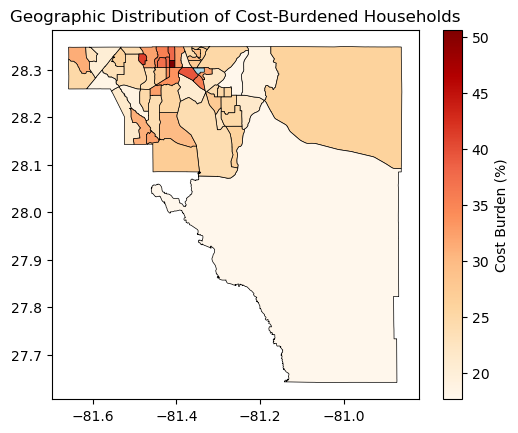

In [14]:
# Plot cost burden households
gdf.plot(column='cost_burden_pct', cmap='OrRd', edgecolor='black', linewidth=0.5, legend=True,
         legend_kwds={'label': "Cost Burden (%)", 'orientation': "vertical"},
         missing_kwds={'color': 'lightblue', 'label': 'Missing Data'})

plt.title("Geographic Distribution of Cost-Burdened Households")
plt.show()

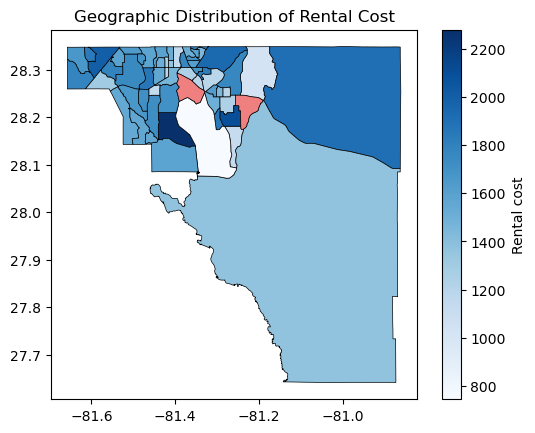

In [15]:
# Plot rent house cost
gdf.plot(column='housecost_rent_est', cmap='Blues', edgecolor='black', linewidth=0.5, legend=True,
         legend_kwds={'label': "Rental cost",'orientation': "vertical"},
         missing_kwds={'color': 'lightcoral', 'label': 'Missing Data'})

plt.title("Geographic Distribution of Rental Cost")
plt.show()

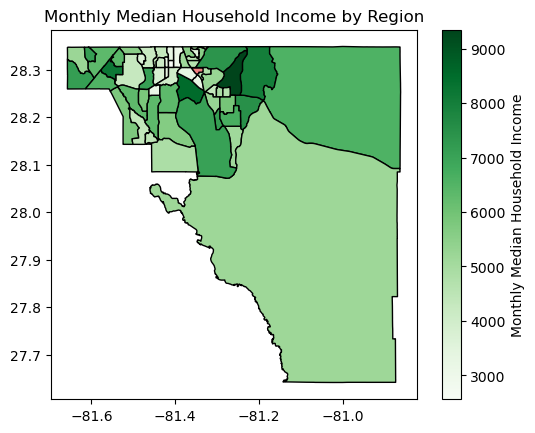

In [16]:
# Plot the median household income
gdf.plot(column='med_hh_inc_monthly', cmap='Greens', edgecolor='black', legend=True,
         legend_kwds={'label': "Monthly Median Household Income", 'orientation': "vertical"},
         missing_kwds={'color': 'lightcoral', 'label': 'Missing Data'})

plt.title("Monthly Median Household Income by Region")
plt.show()

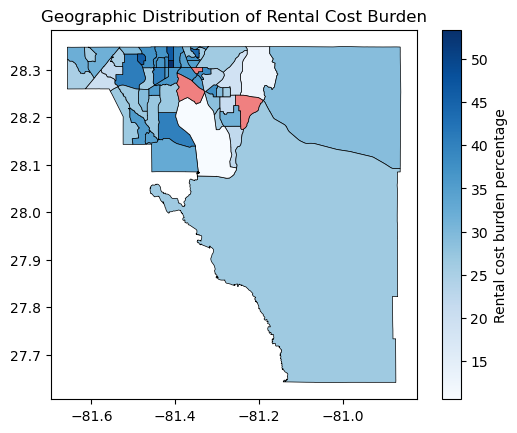

In [17]:
# Plot the cost burden percentage for renters
gdf.plot(column='cost_burden_rent_pct', cmap='Blues', edgecolor='black', linewidth=0.5, legend=True,
         legend_kwds={'label': "Rental cost burden percentage",'orientation': "vertical"},
         missing_kwds={'color': 'lightcoral', 'label': 'Missing Data'})

plt.title("Geographic Distribution of Rental Cost Burden")
plt.show()

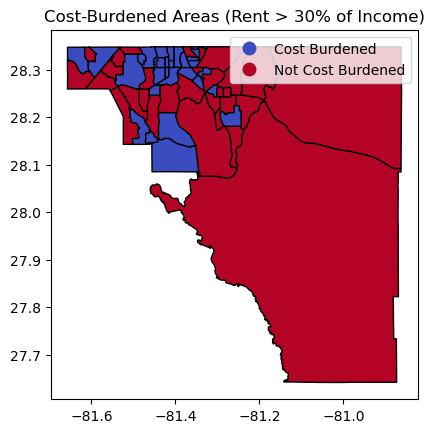

In [18]:
# Column created to mark areas where rent burden is greater than 30%
gdf['is_cost_burdened'] = gdf['cost_burden_rent_pct'] > 30
gdf['is_cost_burdened'] = gdf['is_cost_burdened'].map({True: 'Cost Burdened', False: 'Not Cost Burdened'})

# Plot the areas that are cost-burdened with a categorical color map
gdf.plot(column='is_cost_burdened', cmap='coolwarm', edgecolor='black', legend=True,
         missing_kwds={'color': 'lightcoral', 'label': 'Missing Data'})  

plt.title("Cost-Burdened Areas (Rent > 30% of Income)")
plt.show()

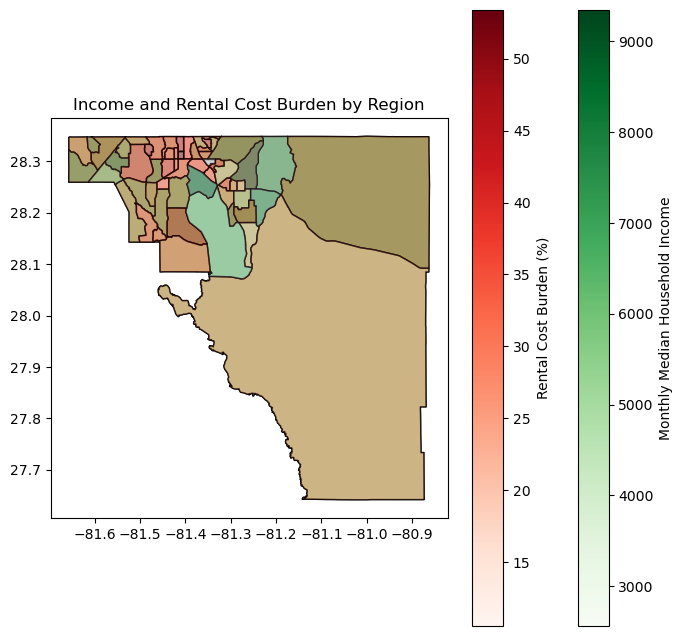

In [19]:
# Overlay Income and Cost burden
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot the median household income as the base layer
gdf.plot(column='med_hh_inc_monthly', cmap='Greens', edgecolor='black', legend=True,
         legend_kwds={'label': "Monthly Median Household Income", 'orientation': "vertical"},
         missing_kwds={'color': 'lightgrey', 'label': 'Missing Data'},
         ax=ax)

# Overlay the cost burden map
gdf.plot(column='cost_burden_rent_pct', cmap='Reds', alpha=0.5, edgecolor='black', ax=ax, legend=True,
         legend_kwds={'label': "Rental Cost Burden (%)", 'orientation': "vertical"},
         missing_kwds={'color': 'lightgrey', 'label': 'Missing Data'})

plt.title("Income and Rental Cost Burden by Region")
plt.show()

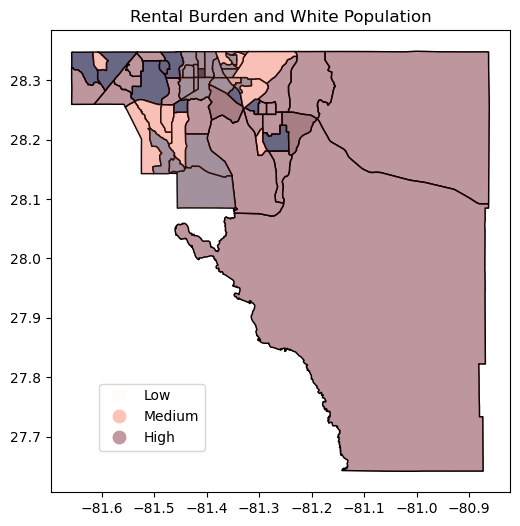

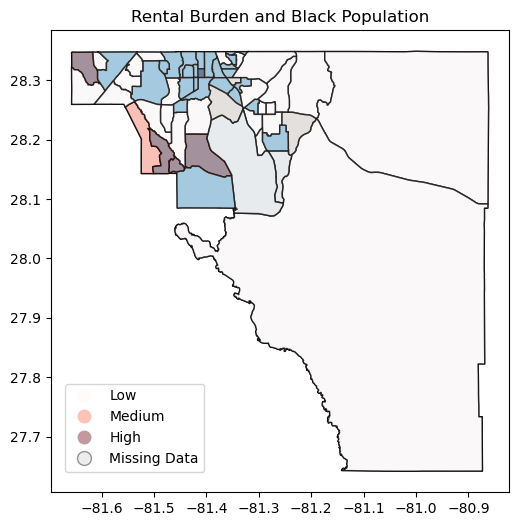

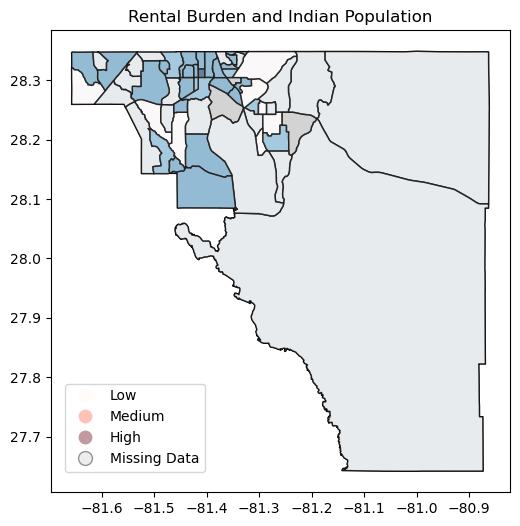

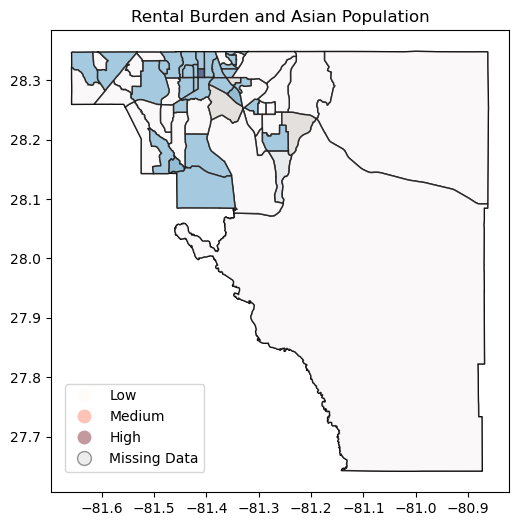

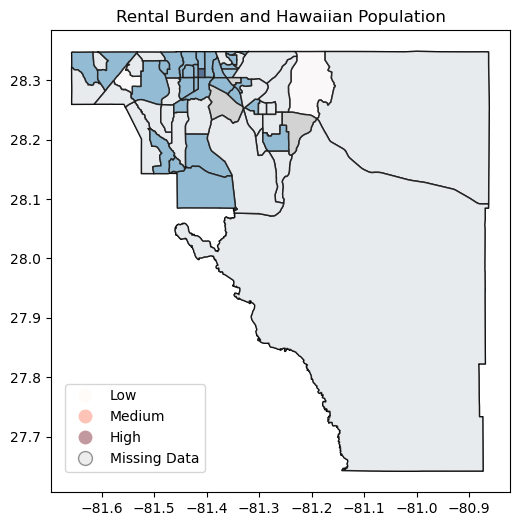

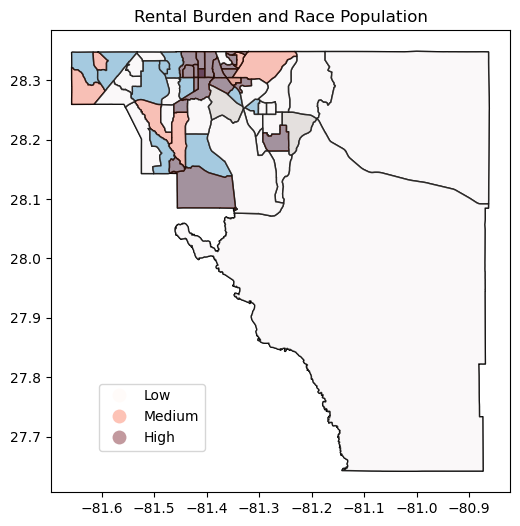

In [20]:
# Define bins and labels for rental cost burden and racial percentages
bins_burden = [0, 30, 50, 100]  # Rent burden categories: Low (0-30%), Medium (30-50%), High (50%+)
labels_burden = ['Low', 'Medium', 'High']

bins_race = [0, 20, 50, 100]  # Racial percentage categories: Low (0-20%), Medium (20-50%), High (50%+)
labels_race = ['Low', 'Medium', 'High']

# List of racial columns to bin
racial_columns = ['pop_pct_white', 'pop_pct_black', 'pop_pct_american_indian', 'pop_pct_asian', 'pop_pct_native_hawaiian', 'pop_pct_other_race']

# Binning the rental cost burden
gdf['binned_burden'] = pd.cut(gdf['cost_burden_rent_pct'], bins=bins_burden, labels=labels_burden)

# Loop through each racial column and overlay with rental cost burden
for race_col in racial_columns:
    # Create a binned version of the racial percentage column
    gdf[f'binned_{race_col}'] = pd.cut(gdf[race_col], bins=bins_race, labels=labels_race)

    # Create a new figure and axis for the overlay
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Plot the binned rental cost burden as the base layer
    gdf.plot(column='binned_burden', cmap='Blues', edgecolor='black', legend=True, ax=ax,
             missing_kwds={'color': 'lightgrey', 'label': 'Missing Data'})
    
    # Overlay the binned racial demographic data (e.g., White population)
    gdf.plot(column=f'binned_{race_col}', cmap='Reds', edgecolor='black', alpha=0.4, ax=ax,
             legend=True, missing_kwds={'color': 'lightgrey', 'label': 'Missing Data'})
    
    # Move the legend for better clarity
    ax.get_legend().set_bbox_to_anchor((0.35, 0.25)) 
    
    plt.title(f"Rental Burden and {race_col.split('_')[-1].capitalize()} Population")
    plt.show()

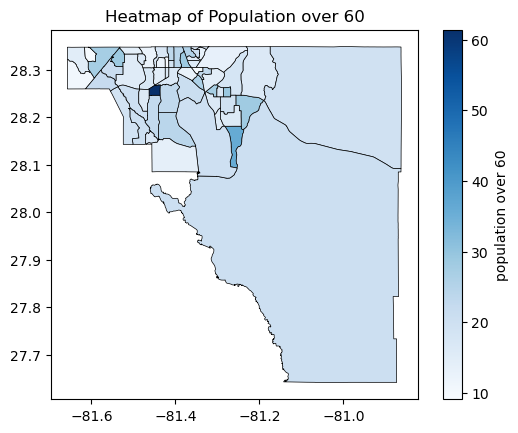

In [21]:
# Plot a heatmap for population over 60
gdf.plot(column='pop_pct_60plus_est', cmap='Blues', linewidth=0.5, legend=True,
         legend_kwds={'label': "population over 60", 'orientation': "vertical"},
         missing_kwds={'color': 'lightcoral', 'label': 'Missing Data'}, edgecolor='black')

plt.title("Heatmap of Population over 60")
plt.show()

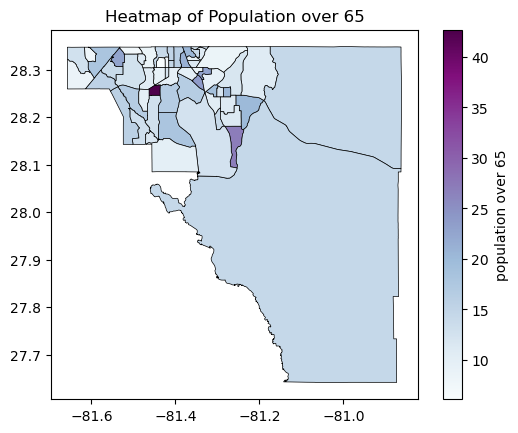

In [22]:
# Plot a heatmap for population over 65
gdf.plot(column='pop_pct_65plus_est', cmap='BuPu', linewidth=0.5, legend=True,
         legend_kwds={'label': "population over 65", 'orientation': "vertical"},
         missing_kwds={'color': 'lightcoral', 'label': 'Missing Data'}, edgecolor='black')

plt.title("Heatmap of Population over 65")
plt.show()

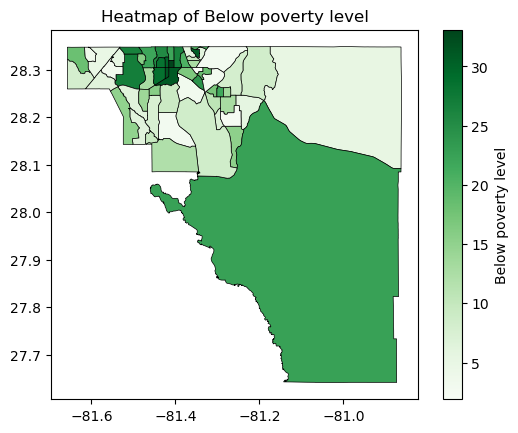

In [23]:
# Plot a heatmap for below poverty level
gdf.plot(column='pov_pct_est', cmap='Greens', linewidth=0.5, legend=True,
         legend_kwds={'label': "Below poverty level", 'orientation': "vertical"},
         missing_kwds={'color': 'lightcoral', 'label': 'Missing Data'}, edgecolor='black')

plt.title("Heatmap of Below poverty level")
plt.show()

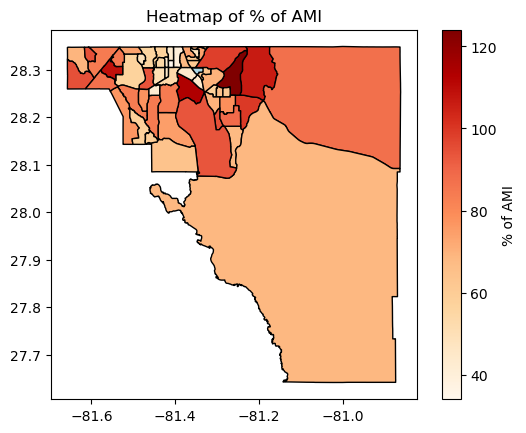

In [24]:
# Plot a heatmap for % of AMI
gdf.plot(column='ami_pct', cmap='OrRd', legend=True,
         legend_kwds={'label': "% of AMI", 'orientation': "vertical"},
         missing_kwds={'color': 'lightblue', 'label': 'Missing Data'},edgecolor='black')

plt.title("Heatmap of % of AMI")
plt.show()

In [25]:
# Normalize the variables (bring them to the same scale: 0 to 1)
gdf['normalized_cost_burden'] = gdf['cost_burden_rent_pct'] / gdf['cost_burden_rent_pct'].max()
gdf['normalized_ami'] = (100 - gdf['ami_pct']) / 100  # Inverted so that low AMI = high need
gdf['normalized_pop_over_60'] = gdf['pop_pct_60plus_est'] / 100  # Convert % to 0-1 scale

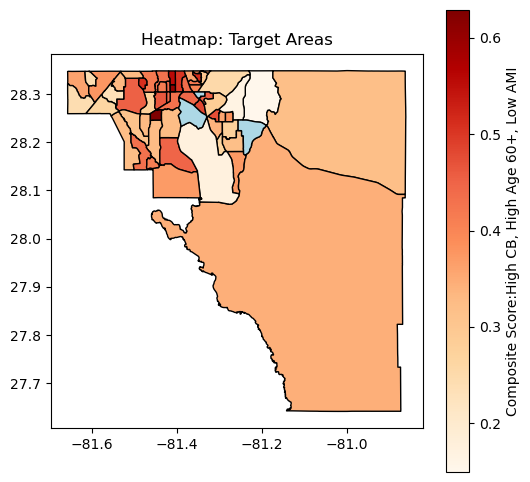

In [26]:
# Weights for each variable
weight_cost_burden = 0.4
weight_pop_over_60 = 0.4
weight_ami = 0.2

# Create composite score (weighted sum of normalized variables)
gdf['composite_score'] = (
    (gdf['normalized_cost_burden'] * weight_cost_burden) + 
    (gdf['normalized_pop_over_60'] * weight_pop_over_60) +
    (gdf['normalized_ami'] * weight_ami)
)

# Plot the composite score
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
gdf.plot(column='composite_score', cmap='OrRd', edgecolor='black', legend=True,
         legend_kwds={'label': "Composite Score:High CB, High Age 60+, Low AMI", 'orientation': "vertical"},
         missing_kwds={'color': 'lightblue', 'label': 'Missing Data'},
         ax=ax)

plt.title("Heatmap: Target Areas")
plt.show()

## Multivariate Regression Analysis

In [27]:
data_reg = data_clean.dropna()
# Independent variables including housing costs and demographics
X_multi = data_reg[['housecost_med_est', 'housecost_rent_est', 'pop_pct_black', 'pop_pct_60plus_est', 'pov_pct_est']]

# Dependent variable (median household income)
y_multi = data_reg['med_hh_inc_monthly']

# Add constant
X_multi = sm.add_constant(X_multi)

# Perform multiple regression
model_multi = sm.OLS(y_multi, X_multi).fit()

# Summary of the multiple regression model
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:     med_hh_inc_monthly   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     20.70
Date:                Tue, 24 Sep 2024   Prob (F-statistic):           4.70e-11
Time:                        21:00:21   Log-Likelihood:                -447.31
No. Observations:                  55   AIC:                             906.6
Df Residuals:                      49   BIC:                             918.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4053.5385   1362